## Cellule 1 - Importations et définitions de fonctions

In [1]:
# Importation des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.patches import Rectangle, Circle
import scipy.constants as constants

# ===============================
# Utilitaires & constantes
# ===============================
G = constants.g  # accélération gravitationnelle ~ 9.81 m/s²
PI = np.pi

def rpm_to_omega(rpm: float) -> float:
    """Convertit des tours/minute (rpm) en vitesse angulaire (rad/s)."""
    return (rpm * 2.0 * PI) / 60.0

# ===============================
# Calculs de centrifugation
# ===============================
def calculate_rcf(rpm: float, radius_mm: float) -> float:
    """Calcule le facteur de force relative (RCF, en g)."""
    r_cm = radius_mm / 10.0
    rcf = 1.118e-5 * r_cm * (rpm ** 2)
    return rcf

def stokes_law(diameter: float,
               particle_density: float,
               medium_density: float,
               viscosity: float,
               rpm: float,
               radius: float) -> float:
    """
    Vitesse de sédimentation (m/s) selon la loi de Stokes sous centrifugation.
    v = (Δρ * d^2 * ω^2 * r) / (18 * μ)
    """
    delta_rho = (particle_density - medium_density)
    omega = rpm_to_omega(rpm)
    v = (delta_rho * (diameter ** 2) * (omega ** 2) * radius) / (18.0 * viscosity)
    return v

# ===============================
# Presets pour différents échantillons
# ===============================
SAMPLE_PRESETS = {
    "Lait":            {"d": 0.8e-6,  "rho_p": 1030, "rho_m": 1020, "mu": 2.0e-3, "r": 0.1},
    "Jus de fruit":    {"d": 7.0e-6,  "rho_p": 1070, "rho_m": 1000, "mu": 1.5e-3, "r": 0.1},
    "Broyat végétal":  {"d": 30.0e-6, "rho_p": 1100, "rho_m": 1000, "mu": 2.5e-3, "r": 0.1},
    "Levures":         {"d": 6.0e-6,  "rho_p": 1100, "rho_m": 1000, "mu": 2.0e-3, "r": 0.1},
}

# ===============================
# Outil d'optimisation simple
# ===============================
def optimize_centrifugation(rpm: int, time: int, temperature: int, sample_type: str):
    """
    Estime un temps de sédimentation de 10 cm pour un type d'échantillon.
    """
    p = SAMPLE_PRESETS.get(sample_type, SAMPLE_PRESETS["Lait"]).copy()
    # Correction simplifiée de viscosité avec température
    Tref = 293.15
    T = 273.15 + float(temperature)
    A = 600.0
    p["mu"] = p["mu"] * np.exp(A * (1.0/T - 1.0/Tref))

    v = stokes_law(p["d"], p["rho_p"], p["rho_m"], p["mu"], rpm, p["r"])
    distance = 0.10  # 10 cm
    t_sec = np.inf if v == 0 else distance / abs(v)
    t_min = t_sec / 60.0
    rcf = calculate_rcf(rpm, radius_mm=p["r"]*1000.0)

    print("—"*60)
    print(f"Type: {sample_type} | Vitesse: {rpm} tr/min | Temp: {temperature}°C | Durée prévue: {time} min")
    print(f"RCF estimée (r={p['r']*1000:.0f} mm): {rcf:.0f} g")
    print(f"Vitesse de sédimentation estimée: {v:.2e} m/s")
    if (p["rho_p"] - p["rho_m"]) < 0:
        print("⚠️ Densité particule < milieu → tendance à flotter.")
    if np.isfinite(t_min):
        print(f"Temps pour parcourir 10 cm: ~ {t_min:.1f} min")
        if t_min < time:
            print("✅ Paramètres suffisants pour espérer un culot en 10 cm.")
        else:
            print("ℹ️ Augmentez la vitesse, la durée, ou la température (dans les limites de l'échantillon) pour accélérer.")
    else:
        print("⚠️ Vitesse nulle — vérifiez les paramètres.")
    return {"velocity_m_s": v, "t10cm_min": t_min, "rcf_g": rcf}

# ===============================
# Simulation de courbes distance vs temps
# ===============================
def simulate_distance_over_time(diameter, particle_density, medium_density,
                                viscosity, rpm, radius, t_max=600, n_points=200):
    """
    Simule la distance parcourue en fonction du temps (s) sous centrifugation.
    Retourne (temps en s, distance en m).
    """
    v = stokes_law(diameter, particle_density, medium_density, viscosity, rpm, radius)
    t = np.linspace(0, t_max, n_points)
    d = v * t
    d = np.clip(d, 0, None)  # pas de valeurs négatives
    return t, d

def plot_sedimentation_curves(sample_type="Lait",
                              rpm_list=[5000, 10000, 15000, 20000],
                              distance=0.10,
                              t_max=600):
    """
    Trace des courbes de distance (cm) vs temps (min) pour différents RPM.
    """
    p = SAMPLE_PRESETS.get(sample_type, SAMPLE_PRESETS["Lait"])
    plt.figure(figsize=(6,4))
    for rpm in rpm_list:
        t, d = simulate_distance_over_time(p["d"], p["rho_p"], p["rho_m"],
                                           p["mu"], rpm, p["r"], t_max=t_max)
        plt.plot(t/60.0, d*100.0, label=f"{rpm} rpm")
    plt.axhline(distance*100, color="k", ls="--", label="10 cm")
    plt.xlabel("Temps (min)")
    plt.ylabel("Distance (cm)")
    plt.title(f"Sédimentation ({sample_type})")
    plt.legend()
    plt.grid(True)
    plt.show()


## Cellule 2 - Configuration de l'affichage des graphiques

In [2]:
# Configuration pour l'affichage des graphiques dans le notebook
try:
    import ipympl  # Vérifie si ipympl est installé
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("matplotlib", "widget")
except Exception:
    # Fallback en inline si ipympl non disponible
    try:
        from IPython import get_ipython
        ip = get_ipython()
        if ip is not None:
            ip.run_line_magic("matplotlib", "inline")
    except Exception:
        pass


## Cellule 3 - Widgets interactifs (RCF & Stokes)

In [7]:
# Widgets interactifs — suppose que les fonctions sont déjà définies (Cellule 1)
try:
    from ipywidgets import interact
except Exception:
    import ipywidgets as widgets
    interact = widgets.interact

def interactive_rcf(rpm=15000, radius_mm=100):
    rcf = calculate_rcf(rpm, radius_mm)
    print(f"Pour {rpm} tr/min et un rayon de {radius_mm} mm:")
    print(f"RCF = {rcf:.2f} g")

def interactive_stokes(diameter=1e-6, particle_density=1180, medium_density=1020, 
                       viscosity=0.01, rpm=15000, radius=0.1):
    velocity = stokes_law(diameter, particle_density, medium_density, viscosity, rpm, radius)
    print(f"Vitesse de sédimentation: {velocity:.2e} m/s")
    if velocity > 0:
        print(f"Temps pour sédimenter de 10 cm: {0.1/velocity/60:.2f} min")
    else:
        print("Les particules flottent!")

# Interfaces interactives
interact(interactive_rcf, rpm=(1000, 30000, 500), radius_mm=(50, 200, 10))
interact(interactive_stokes,
         diameter=(1e-9, 1e-5, 1e-9),
         particle_density=(1000, 2000, 50),
         medium_density=(800, 1200, 10),
         viscosity=(0.001, 0.1, 0.001),
         rpm=(1000, 30000, 500),
         radius=(0.05, 0.2, 0.01))


interactive(children=(IntSlider(value=15000, description='rpm', max=30000, min=1000, step=500), IntSlider(valu…

interactive(children=(FloatSlider(value=1e-06, description='diameter', max=1e-05, min=1e-09, step=1e-09), IntS…

<function __main__.interactive_stokes(diameter=1e-06, particle_density=1180, medium_density=1020, viscosity=0.01, rpm=15000, radius=0.1)>

## Cellule 4 - Simulation des courbes de sédimentation

In [8]:
# Cellule 4 : Simulation et visualisation des courbes de sédimentation
import ipywidgets as widgets
from ipywidgets import interact

def interactive_plot(sample_type="Lait",
                     rpm_list_str="5000,10000,15000,20000",
                     t_max_min=10):
    try:
        rpm_list = [int(v.strip()) for v in rpm_list_str.split(",") if v.strip().isdigit()]
    except Exception:
        rpm_list = [10000, 20000]
    plot_sedimentation_curves(sample_type=sample_type,
                              rpm_list=rpm_list,
                              distance=0.10,
                              t_max=t_max_min*60)

interact(interactive_plot,
         sample_type=widgets.Dropdown(options=list(SAMPLE_PRESETS.keys()),
                                      value="Lait",
                                      description="Échantillon:"),
         rpm_list_str=widgets.Text(value="5000,10000,15000,20000",
                                   description="RPMs (séparés par ,):",
                                   layout=widgets.Layout(width="70%")),
         t_max_min=widgets.IntSlider(min=1, max=60, step=1, value=10,
                                     description="Durée max (min):"))


interactive(children=(Dropdown(description='Échantillon:', options=('Lait', 'Jus de fruit', 'Broyat végétal', …

<function __main__.interactive_plot(sample_type='Lait', rpm_list_str='5000,10000,15000,20000', t_max_min=10)>

## Cellule 5 - Outil d'optimisation interactif

In [9]:
# Interface utilisateur pour explorer les paramètres de centrifugation
try:
    import ipywidgets as widgets
    from ipywidgets import interact
except Exception:
    class _Dummy:
        def __call__(self, *a, **k): 
            print("ipywidgets non disponible — installez-le pour l'interactivité.")
    widgets = type("W", (), {"IntSlider": _Dummy, "Dropdown": _Dummy, "Layout": lambda *a, **k: None})()
    interact = _Dummy()

print("="*60)
print("EXPLORATION INTERACTIVE DES PARAMÈTRES DE CENTRIFUGATION")
print("="*60)

style = {'description_width': 'initial'}
layout = widgets.Layout(width='80%')

interact(optimize_centrifugation,
         rpm=widgets.IntSlider(min=1000, max=30000, step=500, value=15000, 
                              description='Vitesse (tr/min):', style=style, layout=layout),
         time=widgets.IntSlider(min=1, max=120, step=5, value=30, 
                               description='Temps (min):', style=style, layout=layout),
         temperature=widgets.IntSlider(min=0, max=40, step=1, value=4, 
                                      description='Température (°C):', style=style, layout=layout),
         sample_type=widgets.Dropdown(
             options=list(SAMPLE_PRESETS.keys()),
             value='Lait',
             description="Type d'échantillon:",
             style=style,
             layout=layout
         ))


EXPLORATION INTERACTIVE DES PARAMÈTRES DE CENTRIFUGATION


interactive(children=(IntSlider(value=15000, description='Vitesse (tr/min):', layout=Layout(width='80%'), max=…

<function __main__.optimize_centrifugation(rpm: int, time: int, temperature: int, sample_type: str)>

## Démo rapide

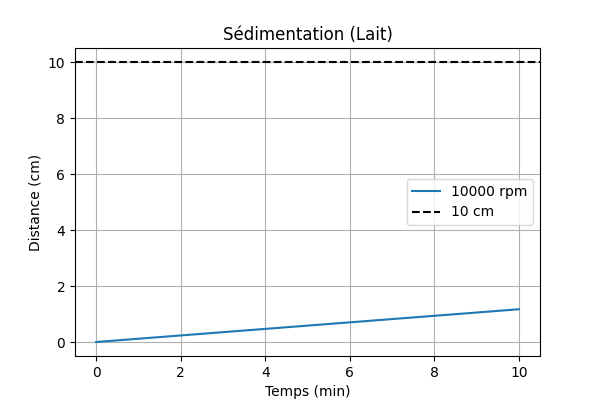

In [10]:
# Exemple de démo : tracer la courbe de sédimentation pour du lait à 10 000 rpm
plot_sedimentation_curves(sample_type='Lait',
                          rpm_list=[10000],
                          distance=0.10,
                          t_max=600)